# empirical CDF-based adaptive score clipping

this notebook refers to [this idea](https://docs.google.com/document/d/1gwDDQBRAN1_wPNQU1-WC33iLv8Gmg15WymTLMvVaBxU/edit?pli=1#heading=h.u7so8r7cc92f)

[geogebra viz](https://www.geogebra.org/m/gusy9swa)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import stats
%matplotlib widget

In [2]:
seed = 0
gen = np.random.Generator(np.random.PCG64(np.random.SeedSequence(seed)))

score_range = np.arange(0, 100, 1)

dist0 = sp.stats.norm(loc=30, scale=5)
dist1 = sp.stats.norm(loc=50, scale=10)

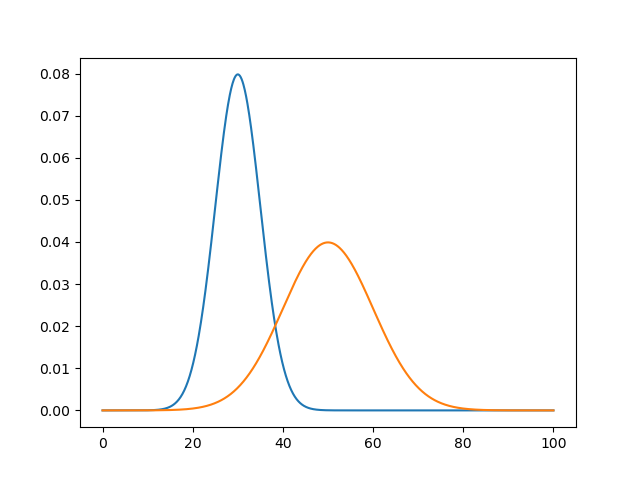

In [56]:
plt.close()
xs = np.linspace(0, 100, 1000)
plt.plot(xs, dist0.pdf(xs))
plt.plot(xs, dist1.pdf(xs))


In [4]:
plt.close()
xs = np.linspace(0, 100, 1000)
plt.plot(xs, dist0.cdf(xs))
plt.plot(xs, dist1.cdf(xs))

In [122]:
SCORE_SAMPLE_SIZE = 3000
sample0 = dist0.rvs(size=SCORE_SAMPLE_SIZE, random_state=gen)
sample1 = dist1.rvs(size=SCORE_SAMPLE_SIZE, random_state=gen)

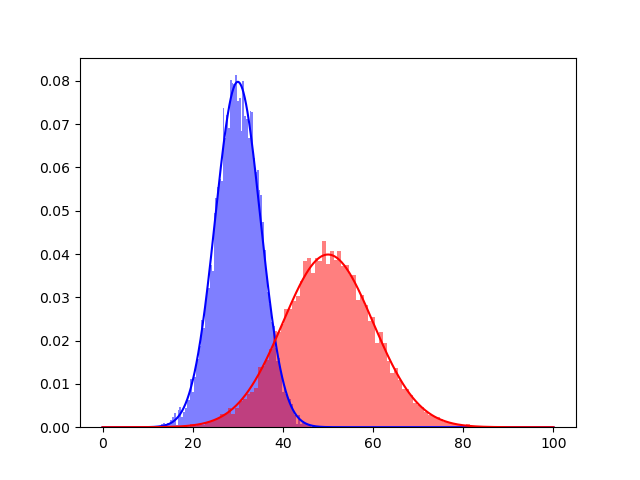

In [117]:
plt.close()
xs = np.linspace(0, 100, 1000)
plt.plot(xs, dist0.pdf(xs), c='b')
plt.plot(xs, dist1.pdf(xs), c='r')
plt.hist(sample0, bins=100, density=True, color='b', alpha=0.5);
plt.hist(sample1, bins=100, density=True, color='r', alpha=0.5);

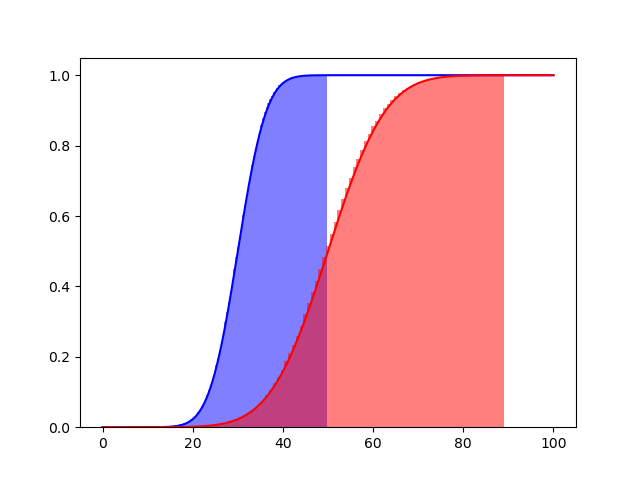

In [116]:
plt.close()
xs = np.linspace(0, 100, 1000)
plt.plot(xs, dist0.cdf(xs), c='b')
plt.plot(xs, dist1.cdf(xs), c='r')
plt.hist(sample0, bins=100, density=True, color='b', alpha=0.5, cumulative=True);
plt.hist(sample1, bins=100, density=True, color='r', alpha=0.5, cumulative=True);

In [160]:
nquantiles = 501
percentiles = np.linspace(0, 100, NPERCENTILES)

points0 = np.array([(np.percentile(sample0, perc), perc / 100) for perc in percentiles])
points1 = np.array([(np.percentile(sample1, perc), perc / 100) for perc in percentiles])

In [161]:
points0_xys = points0.T
points1_xys = points1.T

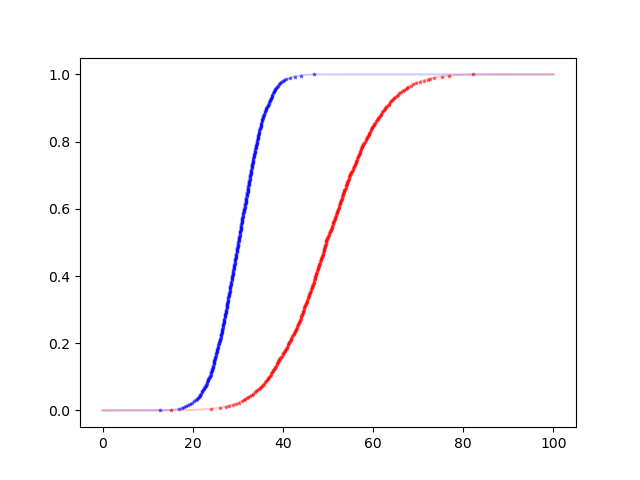

In [153]:
plt.close()
xs = np.linspace(0, 100, 1000)
plt.plot(xs, dist0.cdf(xs), c='b', linestyle='-', alpha=.2)
plt.plot(xs, dist1.cdf(xs), c='r', linestyle='-', alpha=.2)
plt.scatter(*points0_xys.tolist(), marker="*", color='b', alpha=0.5, s=4);
plt.scatter(*points1_xys.tolist(), marker="*", color='r', alpha=0.5, s=4);
plt.show()

In [162]:
from functools import partial
approx_cdf0 = partial(np.interp, xp=points0_xys[0], fp=points0_xys[1], left=0, right=1)
approx_cdf1 = partial(np.interp, xp=points1_xys[0], fp=points1_xys[1], left=0, right=1)


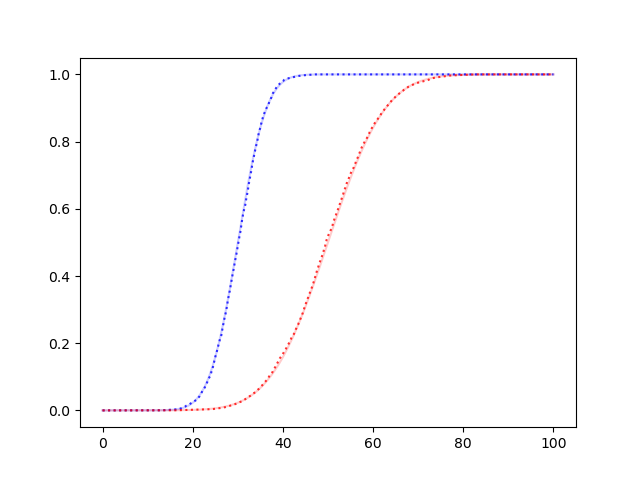

In [155]:
plt.close()
xs = np.linspace(0, 100, 10000)

plt.plot(xs, dist0.cdf(xs), c='b', linestyle='-', alpha=.2)
plt.plot(xs, dist1.cdf(xs), c='r', linestyle='-', alpha=.2)

plt.plot(xs, approx_cdf0(xs), c='b', linestyle=':', alpha=.8)
plt.plot(xs, approx_cdf1(xs), c='r', linestyle=':', alpha=.8)

plt.show()

In [163]:
xs = np.linspace(0, 100, 1000)
err0 = np.abs(dist0.cdf(xs) - approx_cdf0(xs))
err1 = np.abs(dist1.cdf(xs) - approx_cdf1(xs))

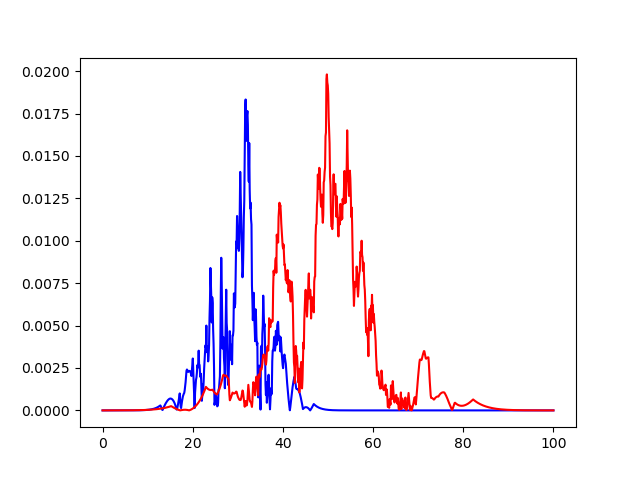

In [164]:
plt.close()
plt.plot(xs, err0, c='b')
plt.plot(xs, err1, c='r')
plt.show()

In [165]:
score_range0 = (points0[0, 0], points0[-1, 0])
score_range1 = (points1[0, 0], points1[-1, 0])

(cutfunc_range_min, cutfunc_range_max) = cutfunc_range = (min(score_range0[0], score_range1[0]), max(score_range0[1], score_range1[1]))

def ideal_cutfunc(scores, normalize=1.0):
    return np.stack([1 - dist0.cdf(scores), dist1.cdf(scores)], axis=1).min(axis=1).clip(0, .5) / normalize

def cutfunc(scores, normalize=1.0):
    return np.stack([1 - approx_cdf0(scores), approx_cdf1(scores)], axis=1).min(axis=1).clip(0, .5) / normalize

# we dont need to search the maximum in the entier range cuz we know its somewhere in the middle
score_median0 = points0[50, 0]
score_median1 = points1[50, 0]
cutfunc_maxsearch_range = (min(score_median0, score_median1), max(score_median0, score_median1))

ideal_cutfunc_max = np.max(ideal_cutfunc(np.linspace(*cutfunc_maxsearch_range, num=1000)))
ideal_cutfunc_normalized = partial(ideal_cutfunc, normalize=ideal_cutfunc_max)

cutfunc_max = np.max(cutfunc(np.linspace(*cutfunc_maxsearch_range, num=1000)))
cutfunc_normalized = partial(cutfunc, normalize=cutfunc_max)

from scipy import signal 

CUTFUNC_THRESHOLD = 0.05
score_search_space = np.linspace(*cutfunc_range, num=1000)
ideal_solutions_args = signal.argrelmin(np.abs(ideal_cutfunc_normalized(score_search_space) - CUTFUNC_THRESHOLD))[0]
approx_solutions_args = signal.argrelmin(np.abs(cutfunc_normalized(score_search_space) - CUTFUNC_THRESHOLD))[0]

ideal_solutions = score_search_space[ideal_solutions_args]
approx_solutions = score_search_space[approx_solutions_args]

assert len(ideal_solutions) == 2
assert len(approx_solutions) == 2

ideal_clipmin, ideal_clipmax = ideal_solutions
approx_clipmin, approx_clipmax = approx_solutions

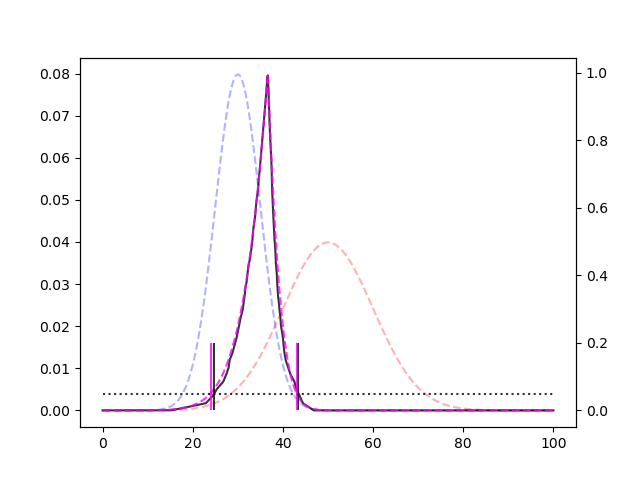

In [166]:
plt.close()
xs = np.linspace(0, 100, 1000)
plt.plot(xs, dist0.pdf(xs), c='b', linestyle='--', alpha=.3)
plt.plot(xs, dist1.pdf(xs), c='r', linestyle='--', alpha=.3)
twinx = plt.twinx()
twinx.plot(xs, cutfunc_normalized(xs), c='k', linestyle='-', alpha=.8)
twinx.plot(xs, ideal_cutfunc_normalized(xs), c='magenta', linestyle='--', alpha=.8)
twinx.plot(xs, CUTFUNC_THRESHOLD * np.ones_like(xs), c='k', linestyle=':', alpha=.8)
twinx.vlines([approx_clipmin, approx_clipmax], 0, .2, color='k', alpha=.8)
twinx.vlines([ideal_clipmin, ideal_clipmax], 0, .2, color='magenta', alpha=.8)
plt.show()

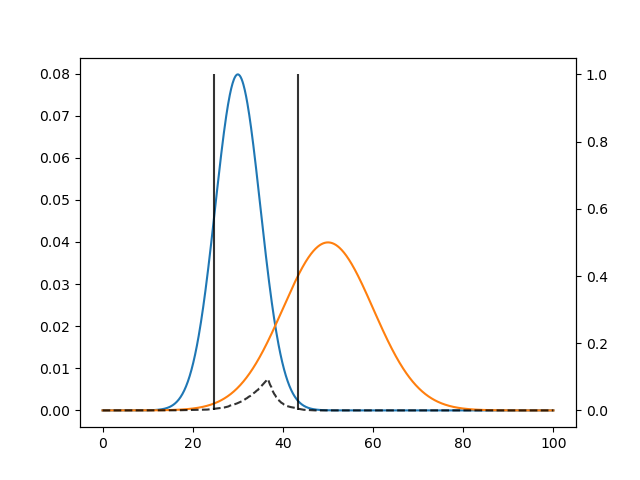

In [174]:
plt.close()
xs = np.linspace(0, 100, 1000)
plt.plot(xs, dist0.pdf(xs))
plt.plot(xs, dist1.pdf(xs))
twinx = plt.twinx()
twinx.plot(xs, cutfunc(xs), c='k', linestyle='--', alpha=.8)
twinx.vlines([approx_clipmin, approx_clipmax], 0, 1, color='k', alpha=.8)
plt.show()

In [1]:
import torch

seed = 0
gen = torch.Generator(device="cuda:3")
gen.manual_seed(seed)

# from up there
# dist0 = sp.stats.norm(loc=30, scale=5)
# dist1 = sp.stats.norm(loc=50, scale=10)
scores_normal = 30. + 5. * torch.randn(4000, generator=gen, device=torch.device('cuda:3'))
scores_anomalous = 50. + 10. * torch.randn(4000, generator=gen, device=torch.device('cuda:3'))

In [2]:
import torch
from torch import Tensor
from typing import Tuple, Optional
import numpy as np
import warnings
from functools import partial
from scipy import signal 

def find_score_clip_values(scores_normal: Tensor, scores_anomalous: Tensor, nquantiles: int = 301, cutfunc_threshold: float = 0.05) -> Optional[Tuple[float, float]]:
        
    MIN_SCORE_SAMPLE_SIZE_WARNING = 3000
    MIN_NQUANTILES = 101

    assert nquantiles >= MIN_NQUANTILES, f"nquantiles={nquantiles}, MIN_NQUANTILES={MIN_NQUANTILES}"
    assert 0 < cutfunc_threshold < 1, f"cutfunc_threshold={cutfunc_threshold}, must be between 0 and 1 (both excluded)"
        
    quantiles = torch.linspace(0, 1, nquantiles, device=scores_normal.device)

    def get_cdf(scores: Tensor) -> Tuple[Tensor, Tuple[float, float, float]]:
        """return a numpy-compatible CDF of the scores and (min, median, max) of the scores"""
        
        scores = scores.view(-1)
        
        if scores.numel() < MIN_SCORE_SAMPLE_SIZE_WARNING:
            # reminder: stacklevel=2 means we're in the function that called this one
            warnings.warn(f"WARNING: scores.numel()={scores.numel()} < {MIN_SCORE_SAMPLE_SIZE_WARNING}", stacklevel=2)
        
        # these are (nquantiles, 2) tensors so it's nota big deal to put them back in the cpu
        # it is necessary because we want to use numpy's interp() function
        points_cdf = torch.stack([torch.quantile(scores_normal, quantiles), quantiles], dim=1).cpu().detach().numpy()

        min_score = points_cdf[0, 0]
        max_score = points_cdf[-1, 0]
        
        if nquantiles % 2 == 1:
            median_score = points_cdf[(nquantiles - 1) // 2, 0]
            
        else:
            # in this case it means that there are the quantiles .5 - \epsilon and .5 + \epsilon, but not .5
            # instead of computing the real median we'll just approximate it as the average of their respective scores
            idx2 = nquantiles // 2    
            idx1 = idx2 - 1
            median_score = (points_cdf[idx1, 0] + points_cdf[idx2, 0]) / 2
        
        # [:, 0] is the scores, [:, 1] is the quantiles
        cdf_func = partial(np.interp, xp=points_cdf[:, 0], fp=points_cdf[:, 1], left=0, right=1)
        
        return cdf_func, (min_score, median_score, max_score)

    cdf_normal, (min_score_normal, median_score_normal, max_score_normal) = get_cdf(scores_normal)
    cdf_anomalous, (min_score_anomalous, median_score_anomalous, max_score_anomalous) = get_cdf(scores_anomalous)

    def cutfunc(scores, normalize=1.0):
        return np.stack([1 - cdf_normal(scores), cdf_anomalous(scores)], axis=1).min(axis=1).clip(0, .5) / normalize

    # we dont need to search the maximum in the entier range cuz we know its somewhere in the middle
    cutfunc_maxsearch_range = (min(median_score_normal, median_score_anomalous), max(median_score_normal, median_score_anomalous))
    cutfunc_max = np.max(cutfunc(np.linspace(*cutfunc_maxsearch_range, num=1000)))
    cutfunc_normalized = partial(cutfunc, normalize=cutfunc_max)

    cutfunc_range = (
        min(min_score_normal, min_score_anomalous),
        max(max_score_normal, max_score_anomalous),
    )
    score_search_space = np.linspace(*cutfunc_range, num=3000)
    solutions_args = signal.argrelmin(np.abs(cutfunc_normalized(score_search_space) - cutfunc_threshold))[0]

    if len(solutions_args) != 2:
        warnings.warn(f"WARNING: len(solutions_args)={len(solutions_args)}, expected 2, returning None (no clipping should be applied)", stacklevel=2)
        # return None

    solutions = score_search_space[solutions_args]
    clipmin, clipmax = solutions

    if clipmin > clipmax:
        clipmin, clipmax = clipmax, clipmin

    return clipmin, clipmax

In [3]:
find_score_clip_values(scores_normal, scores_anomalous)

(20.1644831864426, 39.78674474896173)